# Plotting and Analyzing Light Curves of Eclipsing Binary Stars with `lightkurve`

***

## Learning Goals

By the end of this tutorial, you will:

- Download and plot a light curve file using `astroquery.mast`.
- Download and plot a collection of the light curves using `lightkurve`.
- Create a periodogram of a collection of light curves to find the possible eclipsing binary period. 

This is Part 2 of a two-part tutorial. In a separate notebook for Part 1, `find_eclipse_candidates`, we used Vizier to select our binary star system candidate from a catalog created using the radial velocity method and confirmed that it had multiple TESS light curves in the MIT Quick-Look Pipeline ("QLP") archive. 

## Introduction

From Part 1 of this tutorial:

>The [Apache Point Observatory Galactic Evolution Experiment 2 (APOGEE-2)](https://www.sdss.org/surveys/apogee-2/)  observed near-infrared spectra of hundreds of thousands of stars in our Milky Way. This survey was used to search for stars with spectral lines showing the tell-tale radial velocity shifts associated with stellar binaries. Near the end of the APOGEE-2 survey, the [Transiting Exoplanet Survey Satellite (TESS)](https://tess.mit.edu/) was launched to search for exoplanets using the transit method; eclipses of primary stars by companion stars would also be observable by TESS. Finding a stellar system that has been observed by both surveys would provide confirmation of the properties of the system. 

>In this tutorial, we will load a catalog of binary stellar systems discovered through the radial velocity method and investigate if those systems also have light curves in the MAST archive from the TESS mission. Two sources for those already processed light curves are the TESS Data for Asteroseismology Lightcurves archive from TASOC (the TESS Asteroseismic Science Operations Center) or in the TESS Lightcurves From The MIT Quick-Look Pipeline ("QLP") archive. Though we'll focus on a narrow set of eclipsing binaries with previously-measured properties, the radial velocity catalog we'll be working with has nearly 5000 stellar systems that are yet to be fully characterized. 

Now, we'll actually view and analyze the light curves for just one of the radial velocity-selected stellar systems to see if we can observe an eclipse in the TESS data.

The workflow for this notebook consists of:
- Examining and Plotting the Light Curve .fits Fil
    - Exercise 1
- Combining Multiple Light Curve Products using lightkurve
    - Downloading the light curves
    - Plotting the light curves
- Finding the Period of the Variability using lightkurve
- Additional Exercises

## Imports

- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *astropy.coordinates SkyCoord* for creating sky coordinate objects
- *astropy.units* for units on physical quantities
- *matplotlib.pyplot* for plotting data
- *astroquery.mast Observations* for querying MAST for observations
- *lightkurve* for plotting and analying TESS light curves from the QLP or TASOC archives hosted on MASS

You may need to [install the ```lightkurve``` package using its quickstart guide](https://docs.lightkurve.org/quickstart.html). 

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from astroquery.mast import Observations
import lightkurve as lk

***

## Examining and Plotting the Light Curve .fits File

In Part 1 of the tutorial, we decided to investigate the binary star system with APOGEE ID 2M00085727+7341257 located at RA = 2.238636 degrees, Dec = 73.690475 degrees. The period determined by the analysis of [Price-Whelan et al. 2018 (AJ, 156, 1, 18)](https://ui.adsabs.harvard.edu/abs/2018AJ....156...18P/abstract) was 83.66193 days. For now, we'll enter that information manually and then use astroquery to search for the QLP observations

In [2]:
coord=SkyCoord(ra=2.238636*u.degree, dec=73.690475*u.degree, frame='icrs')
per=83.66193
obs_tbl = Observations.query_region(coord,radius=0.008)
obs_tbl=obs_tbl[obs_tbl['provenance_name']=='QLP']
print(obs_tbl)

intentType obs_collection provenance_name ... srcDen  obsid   distance
---------- -------------- --------------- ... ------ -------- --------
   science           HLSP             QLP ...    nan 39201475      0.0
   science           HLSP             QLP ...    nan 38106544      0.0
   science           HLSP             QLP ...    nan 34983240      0.0
   science           HLSP             QLP ...    nan 34099561      0.0


Our ```obs_tbl``` table from ```astroquery``` includes a column called "dataURL." With this URL, we can directly download the light curve file in .fits format to the harddrive. If it is successfully, 'COMPLETE' will appear as the first output. It will automatically download into the current working directory, unless the ```local_path``` option is set. Also, by default, the file will not download again if the file is already found on the harddrive. To see how to change this and other settings you can [view the ```Observations.download_file``` documentation](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html#astroquery.mast.ObservationsClass.download_file). To download multiple files at once, use ```Observations.download_products``` instead.  

In [3]:
url=obs_tbl[0]['dataURL']
Observations.download_file(url)
# JRK this is actually uri not URL? Confused. 

INFO: Found cached file /Users/jkamenetzky/GitHub/notebooks-stsci/notebooks/MAST/plot_analyze_with_lightkurve/hlsp_qlp_tess_ffi_s0018-0000000373283207_tess_v01_llc.fits with expected size 72000. [astroquery.query]


('COMPLETE', None, None)

We can use ```fits``` from ```astropy``` to examine the light curve file. The filename will be the last part of the url string, when separated by slashes.

In [4]:
filename=url.split('/')[-1]
lcfits=fits.open(filename)
lcfits.info()

Filename: hlsp_qlp_tess_ffi_s0018-0000000373283207_tess_v01_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU     65   1107R x 13C   [D, J, E, E, E, J, J, E, E, E, E, E, E]   


The TESS light curve file has two extensions:

- No. 0 (Primary): This HDU (Header Data Unit) contains metadata related to the entire file.
- No. 1 (Light Curve): This HDU contains a binary table that holds data like flux measurements and times. We will extract information from here when we define the parameters for the light curve plot.

We can preview the contents of the second file extension by examining the names of the columns and the first few lines of data.

In [5]:
print(lcfits[1].columns)
print(lcfits[1].data[0:5])

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD-2457000, days'
    name = 'CADENCENO'; format = 'J'
    name = 'SAP_FLUX'; format = 'E'
    name = 'KSPSAP_FLUX'; format = 'E'
    name = 'KSPSAP_FLUX_ERR'; format = 'E'
    name = 'QUALITY'; format = 'J'
    name = 'ORBITID'; format = 'J'
    name = 'SAP_X'; format = 'E'; unit = 'pixel'
    name = 'SAP_Y'; format = 'E'; unit = 'pixel'
    name = 'SAP_BKG'; format = 'E'
    name = 'SAP_BKG_ERR'; format = 'E'
    name = 'KSPSAP_FLUX_SML'; format = 'E'
    name = 'KSPSAP_FLUX_LAG'; format = 'E'
)
[(1790.68018644, 27034, 0.9677139 , 1.0017732, 0.00369792, 4096, 43, 171.42014, 1276.1276, 623.68, 1048.87, 1.000957 , 1.0035249 )
 (1790.70102002, 27035, 0.9719843 , 1.0031046, 0.00369792, 4096, 43, 171.41783, 1276.131 , 179.44, 1076.92, 1.0003365, 1.0048736 )
 (1790.72185361, 27036, 0.96478045, 0.993276 , 0.00369792, 4096, 43, 171.41919, 1276.1296, 446.8 , 1027.99, 0.9969646, 0.9932044 )
 (1790.74268719, 27037, 0.97234386, 0.9992326, 0.0036

Detailed information about the QLP data products can be found linked at the [MAST QLP website](https://archive.stsci.edu/hlsp/qlp) in the [QLP Data Production Description Document](https://archive.stsci.edu/hlsps/qlp/hlsp_qlp_tess_ffi_all_tess_v1_data-prod-desc.pdf), a supplement to the RNAAS article ([Kunimoto et al., 2021, RNAAS, 5, 10, 234](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..234K/abstract)) that describes the process for creating the QLP light curves. 

At its most basic, a light curve is a plot of flux on the vertical axis vs. time on the horizontal axis. We can use ```matplotlib``` to take a very quick look at the data, but first you likely noted that there are two different columns of fluxes in the FITS data. As described in [Kunimoto et al. 2021](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..234K/abstract), SAP_FLUX is the un-detrended flux from the optical aperture and KSPSAP_FLUX is the detrended flux. As we can see below, from plotting the two types of fluxes, the detrended light curve (KSPSAP) filters out the long timescale variation; this long timescale variation is caused by intrinsic stellar variations, but we want to filter that out when searching for eclipses and transits. 

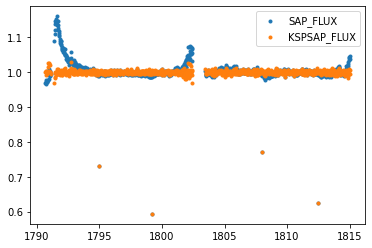

In [6]:
plt.scatter(lcfits[1].data['TIME'],lcfits[1].data['SAP_FLUX'],label='SAP_FLUX',marker='.')
plt.scatter(lcfits[1].data['TIME'],lcfits[1].data['KSPSAP_FLUX'],label='KSPSAP_FLUX',marker='.')
plt.legend()

There are some notably low flux measurements, but they appear to be individual data points, not prolonged transits or eclipses. We will investigate these more below.

Is this enough information to find our eclipse? By eye, it looks like this light curve spans about 25 days. Let's confirm.

In [7]:
print(np.max(lcfits[1].data['TIME'])-np.min(lcfits[1].data['TIME']))

24.33334324027419


The period of our stellar system as determined by the radial velocity method was about 84 days, but one individual QLP light curve only spans about 25 days. It would be best to make use of the multiple datasets available. As our analysis needs get more complicated, it's best to turn to a package that has our downloading, plotting, and analysis tools built in: `lightkurve`.

### Exercise 1

Use the documentation linked above and the [FITS Headers](https://docs.astropy.org/en/stable/io/fits/usage/headers.html) documentation from astropy to answer the following questions:
1. Is the magnitude of this target included, and if so, what is it?
2. Is the mass of this target included, and if so, what is it? 
3. What was the mass determined in the RV catalog? (You'll need to go back to Part 1 of the tutorial to complete this step!)

In [8]:
# Place for code for Exercise 2
# My solutions for Exercise 2:
print(lcfits[0].header['TESSMAG'])
print(lcfits[0].header['MASS'])
# The magnitude is 13.3269. 
# The mass is NOT included in the catalog. The mass from the RV catalog is 1.2 stellar masses.

13.3269
-1.0


## Combining Multiple Light Curve Products using lightkurve
The Lightkurve package can also search the MAST archive and download all light curve products associated with a target stellar system. As we'll see, this package is built specifically to plot and work with light curves in ways that will be easier than the `matplotlib` plotting we were doing above. This portion of the tutorial is based on lightkurve's [Combining multiple quarters of Kepler data](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-combining-multiple-quarters.html) tutorial.

In [9]:
search_result=lk.search_lightcurve(coord,author="QLP")
print(search_result)

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 18 2019    QLP    1800   373283207      0.0
  1 TESS Sector 19 2019    QLP    1800   373283207      0.0
  2 TESS Sector 24 2020    QLP    1800   373283207      0.0
  3 TESS Sector 25 2020    QLP    1800   373283207      0.0


### Downloading the light curves

In [10]:
lc_collection=search_result.download_all()
lc_collection

LightCurveCollection of 4 objects:
    0: <TessLightCurve LABEL="TIC 373283207" SECTOR=18 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 373283207" SECTOR=19 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    2: <TessLightCurve LABEL="TIC 373283207" SECTOR=24 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    3: <TessLightCurve LABEL="TIC 373283207" SECTOR=25 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

By choosing download_all, we create `LightCurveCollection` (basically, an array) of LightCurve products. By examining the first index in the collection, we can see that the columns are the same as in the .fits file that we downloaded thorugh `astroquery`, above. 

In [11]:
lc_0=lc_collection[0]
lc_0

time,flux,flux_err,cadenceno,sap_flux,kspsap_flux,kspsap_flux_err,quality,orbitid,sap_x,sap_y,sap_bkg,sap_bkg_err,kspsap_flux_sml,kspsap_flux_lag
,,,,,,,,,pix,pix,,,,
Time,float32,float32,int32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32
1790.6801864393085,0.9677138924598694,0.0036979245487600565,27034,0.9677139,1.0017732,0.0036979245,4096,43,171.42013549804688,1276.1275634765625,623.68,1048.87,1.000957,1.0035249
1790.70102002479,0.971984326839447,0.0036979245487600565,27035,0.9719843,1.0031046,0.0036979245,4096,43,171.41783142089844,1276.1309814453125,179.44,1076.92,1.0003365,1.0048736
1790.721853608647,0.9647804498672485,0.0036979245487600565,27036,0.96478045,0.993276,0.0036979245,4096,43,171.419189453125,1276.129638671875,446.8,1027.99,0.9969646,0.9932044
1790.742687191012,0.9723438620567322,0.0036979245487600565,27037,0.97234386,0.9992326,0.0036979245,4096,43,171.41798400878906,1276.1304931640625,290.9,862.25,1.0009333,0.99838513
1790.7635207718536,0.977621853351593,0.0036979245487600565,27038,0.97762185,1.0033098,0.0036979245,4096,43,171.4188232421875,1276.1298828125,148.66,1082.57,1.003577,1.0015497
1790.784354351268,0.9709927439689636,0.0036979245487600565,27039,0.97099274,0.995568,0.0036979245,4096,43,171.41729736328125,1276.1287841796875,261.52,1067.28,0.99910975,0.9963929
1790.8051879292327,0.9756560325622559,0.0036979245487600565,27040,0.97565603,0.99971545,0.0036979245,4096,43,171.4173583984375,1276.13037109375,196.66,1277.33,1.0011214,0.99924755
1790.826021505839,0.9727867245674133,0.0036979245487600565,27041,0.9727867,0.99636143,0.0036979245,4096,43,171.41822814941406,1276.1300048828125,292.17,1209.57,0.997881,0.9970241


### Plotting the light curves
We can use lightkurve's built in plotting feature to assure ourselves that we have downloaded the same dataset as we did above with ```astroquery```. This also helps us to confirm that by default, the lightkurve plotting function uses the ```sap_flux``` on the flux axis, rather than the detrended ```kspsap_flux```; the ```sap_flux``` can be used for studies of stellar variability, but these signals need to be removed from the light curve for detailed studies of eclipses and transits.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

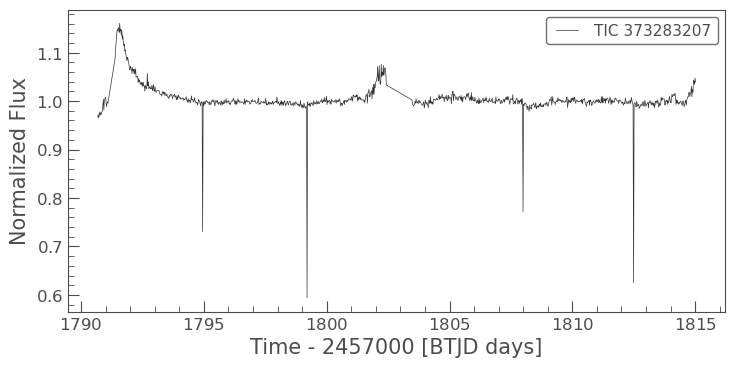

In [12]:
lc_0.plot()

We must be sure to specify that we want to use ```kspsap_flux``` from now on, as below.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='kspsap_flux'>

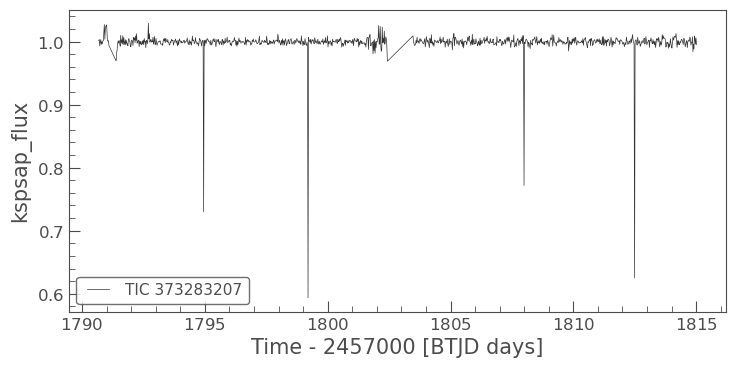

In [13]:
lc_0.plot(column='kspsap_flux')

To combine all datasets as one, we can use the built-in stitching method.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='kspsap_flux'>

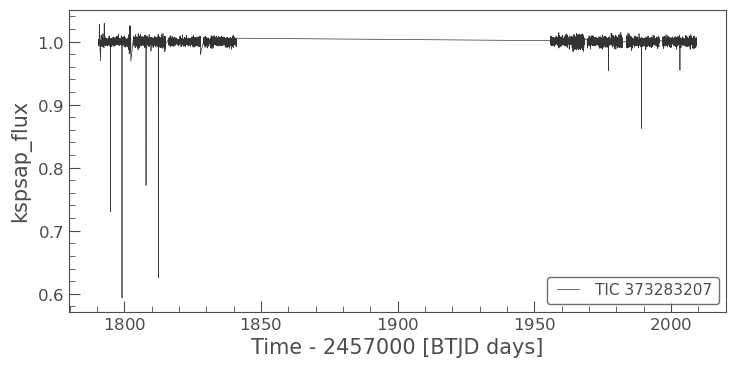

In [14]:
lc_stitched=lc_collection.stitch()
lc_stitched.plot(column='kspsap_flux')

Examining the full amount of data available, we can see that the target of interest was observed in two TESS Sectors back-to-back (Sectors 18 and 19) and then again in Sectors 24 and 25, with a gap of approximately 100 days between the end of Sector 19 and the beginning of Sector 24. These sector numbers were listed in ```search_result``` above. 

It's tempting to look at some of these dips as transits or eclipses in the data! However, the non-zero values in the `quality` column are worth investigating. The tutorial [Instrumental Noise in Kepler and K2 /#1: Data Gaps and Quality Flags](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-kepler-noise-1-data-gaps-and-quality-flags.html), though specific to Kepler and not TESS, is still useful to consult. It provides a way to investigate "decode" each flag. In our case, we want to reference the [QLP Data Production Description Documents](https://archive.stsci.edu/hlsps/qlp/hlsp_qlp_tess_ffi_all_tess_v1_data-prod-desc.pdf) to decode the flags after we review which unique ones are in our dataset and how prevalent they are.

In [15]:
for flag in np.unique(lc_stitched.quality):
    print('Number of datapoints with flag '+str(flag)+': '+str(np.sum(lc_stitched.quality==flag)))

Number of datapoints with flag 0: 3858
Number of datapoints with flag 4096: 786


From the above, we can see that about 17% of our rows contain flag 4096, "Low precision points. The cadence was excluded because low precision data occurred in a large fraction of the stars" (from the documentation linked above). What do our light curves look like if we only plot the rows whose quality flag = 0?

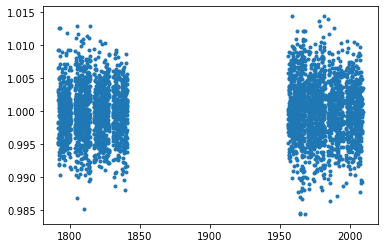

In [16]:
plt.scatter(lc_stitched['time'][lc_stitched['quality']==0].value,
         lc_stitched['kspsap_flux'][lc_stitched['quality']==0],marker='.')

As suspected, the low flux measurements are no longer visible, as they were spurious individual data points rather than transits or eclipses. We'll still continue to use the tools in `lightkurve` to discover if there are any periodic changes to the light curve that might not be noticeable to our eyes. 

## Finding the Period of the Variability using lightkurve

Could the same 84 day period computed with the APOGEE dataset be present in our data?

`lightkurve` has built-in methods for finding the periodicity embedded in the light curve; the result is what's known as a periodogram. This portion of the tutorial is based off of the [What are Periodogram objects?](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-periodogram-objects.html#What-are-Periodogram-objects?) and [Creating periodograms and identifying significant peaks](http://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html) tutorials; the second link in particular has more background information about the mathematics behind periodograms.

By default, the methods below will use the lc_stitched.flux property. As we saw above, by default, this is the ```sap_flux``` column and it includes some data points with non-zero quality flags. Before we continue, we will only choose datapoints whose quality flag is zero. We will set the flux to match the ```kspsap_flux``` column instead (and likewise, we will replace flux_err and the metadata key that notes the flux origin).

Next, we create the periodogram object (```pg```) and plot it.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

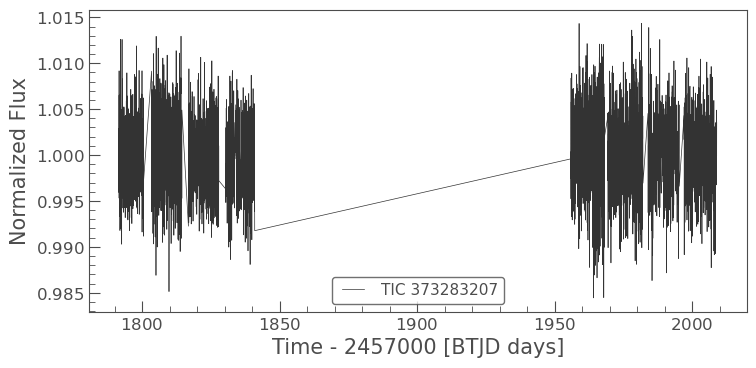

In [17]:
lc_stitched=lc_stitched[lc_stitched['quality']==0]
lc_stitched.flux=lc_stitched['kspsap_flux']
lc_stitched.flux_err=lc_stitched['kspsap_flux_err']
lc_stitched.meta['FLUX_ORIGIN']='kspsap_flux'
lc_stitched.plot()

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

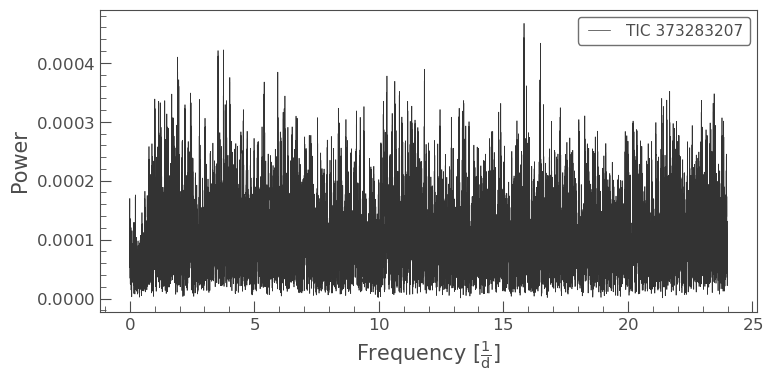

In [18]:
pg=lc_stitched.to_periodogram()
pg.plot()

For the types of periods we are interested in (measured in multiple days), the frequency will be very small, so the view above may not be insightful. Below, we  plot the periodogram with the period on the horizontal axis (instead of frequency) and with both axes in a logarithmic scale. 

On top of the plot, we'll include a vertical line that corresponds with the measured period from Price-Whelan+ 2018 and a dashed vertical line that corresponds to the "Period at Max Power" determined by the periodogram. 

PW+ 2018 period: 83.66193 days
Period at Max Power: 0.06316680930613466 d


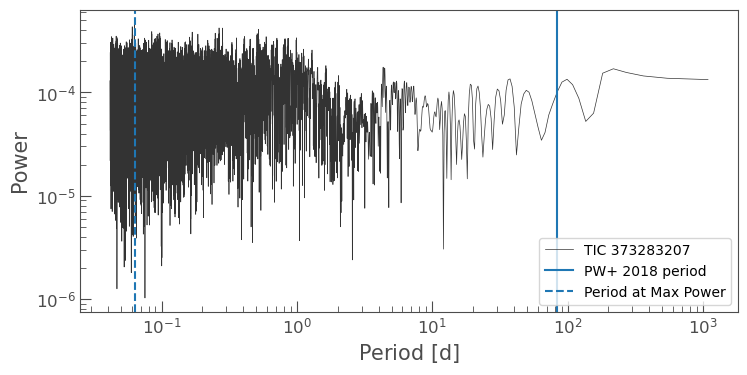

In [19]:
ax=pg.plot(view='period',scale='log')
ax.axvline(per,label='PW+ 2018 period')
ax.axvline(pg.period_at_max_power.value,label='Period at Max Power',linestyle='--')
ax.legend()
print('PW+ 2018 period: '+str(per)+' days')
print('Period at Max Power: '+str(pg.period_at_max_power))

The two periods do not match, and in fact, there is no clear periodicity or repeating signal in the light curve of our target.

One way to check the veracity of a period is to plot the folded light curve. In a folded light curve, phase (in Julian days) appears on the horizontal axis instead of time. In other words, the observations are placed by where they appear in the periodic nature of the change. We can try to view the folded light curve assuming an 83.7 day period.

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

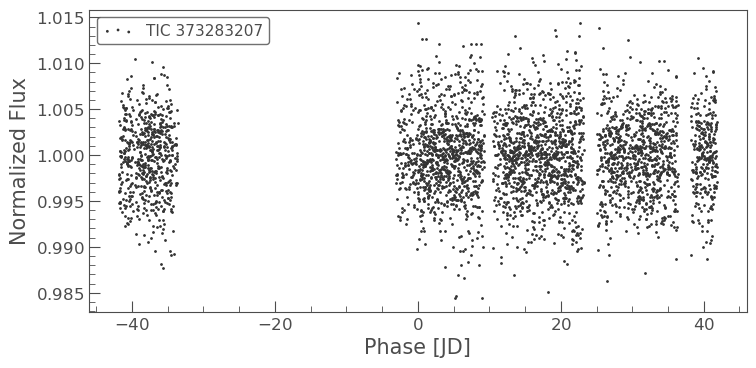

In [20]:
lc_stitched.fold(period=per).scatter()

Unfortunately, no clear eclipse is visible on that timescale. Though this example didn't yield an observable eclipse, there are many (nearly 5000!) candidate binary systems in the Price-Whelan et al. 2018 catalog that may have eclispes observed by TESS! The TASOC and QLP archives contain already processed light curves ready for exploration and discovery. 

## Additional Exercises

1. In Part 1 of the tutorial, `find _eclipse_candidates`, we created a for loop to search for TASOC and QLP observations using astroquery.mast Observations. Load the same `tbl` variable from that tutorial (a filtered version of [Price-Whelan et al. 2018 (AJ, 156, 1, 18)](https://ui.adsabs.harvard.edu/abs/2018AJ....156...18P/abstract) Table 4a, and create a loop to search for TASOC and QLP observation using lk.search_lightcurve instead. Which is faster? 

JRK note, this requires importing Vizier, so do above?

2. Choose another stellar system from PW+2018, plot the stitched light curve, and create the periodogram. Compare the period at maximum power found to the period derived from the radial velocity method.

In [21]:
# Place for code for Exercise 1
# JRK need to do the solution

In [22]:
# Place for code for Exercise 2
# JRK need to do the solution

## Citations

If you use `astropy`, `astroquery`, `lightkurve`, or `VizieR` for published research, please cite the
authors. Follow these links for more information about citing these tools:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* If you use astroquery, please cite the paper [Ginsburg, Sipőcz, Brasseur et al 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157...98G/abstract).
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* [Citing `VizieR`](https://cds.unistra.fr/vizier-org/licences_vizier.html?#copyrightvizier)


## About this Notebook

**Author:** Julia Kamenetzky, ScienceBetter Consultant  
**Last Updated:** Aug 2022  
**Next Review:** Feb 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 